# Analysis

Goal: Analyze the available data to present a concise representation of the movie industry, analyze the success of movies based on various factors, and provide insights and reccomendations for the development of film projects.

As described in the data cleaning notebook and README, this is the methodology for our analysis. This notebook contains all of step 5: data analysis.

Methodology:
    
1. Explore the data to determine what sorts of questions it can help answer.
2. Determine 3 relevant questions to examine. 
3. Clean the data. 
4. Restructure the data so that it can be analyzed.
5. Use data visualizations and statistical analysis to make inferences.
6. Develop a presentation of findings. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%run -i "functions/get_prop.py"
%run -i "functions/make_bins.py"
%run -i "functions/cat_box.py"
%run -i "functions/simple_successdf.py"
%run -i "functions/tiered_successdf.py"
%run -i "functions/calculate_expected.py"
%run -i "functions/simple_rate.py"
%run -i "functions/tiered_rates.py"
%run -i "functions/slice_role.py"


sns.set_style('darkgrid')
sns.set_context('talk')

In [2]:
movies = pd.read_csv('movies.csv')

### Feature Creation

Before I do any financial analysis I'll need to standardize the dollar values to 2019 dollars. I'll base my estimates on an average inflation of 3.16% per year since 1915.  

In [3]:
display(movies['year'].min())
display(movies['year'].max())

1915

2019

In [4]:
movies.head()

,Unnamed: 0,title,genres,averagerating,numvotes,primary_name,status,category,production_budget,domestic_gross,worldwide_gross,month,year,foreign_gross
0,0,#Horror,"Crime,Drama,Horror",3.0,3092,Tara Subkoff,Working,director,1500000,0,0,Nov,2015,0
1,1,#Horror,"Crime,Drama,Horror",3.0,3092,Brendan Walsh,Working,producer,1500000,0,0,Nov,2015,0
2,2,#Horror,"Crime,Drama,Horror",3.0,3092,Oren Segal,Working,producer,1500000,0,0,Nov,2015,0
3,3,#Horror,"Crime,Drama,Horror",3.0,3092,Haley Murphy,Working,actress,1500000,0,0,Nov,2015,0
4,4,#Horror,"Crime,Drama,Horror",3.0,3092,Jason Ludman,Working,producer,1500000,0,0,Nov,2015,0


In [5]:
#Create a dictionary with year keys and inflation rate values.
years = sorted(range(1915,2020), reverse=True)
infl_dict = {}
infl_rate = 1/1.0316
for year in years:
    infl_rate *= 1.0316 
    infl_dict[year] = infl_rate

#Define function to convert dollars to 2019 value.
def adjust(value, year):
    """Return inflation adjusted value."""
    return round(value*infl_dict[year], 2)

#Assign the adjusted values to new columns
movies['adj_dom_gross'] = [
    adjust(movies.loc[row,'domestic_gross'], 
           movies.loc[row,'year']) 
    for row in range(0,len(movies))
    ]
movies['adj_frn_gross'] = [
    adjust(movies.loc[row,'foreign_gross'],
           movies.loc[row,'year']) 
    for row in range(0,len(movies))
    ]
movies['adj_wide_gross'] = [
    adjust(movies.loc[row,'worldwide_gross'],
           movies.loc[row,'year']) 
    for row in range(0,len(movies))
    ]
movies['adj_prod_budg'] = [
    adjust(movies.loc[row,'production_budget'],
           movies.loc[row,'year']) 
    for row in range(0,len(movies))]

#Add a profit column.
movies['profit']=(movies['adj_wide_gross']
                  -movies['adj_prod_budg'])

movies.groupby('title').mean().head()

,Unnamed: 0,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,year,foreign_gross,adj_dom_gross,adj_frn_gross,adj_wide_gross,adj_prod_budg,profit
title,,,,,,,,,,,,,
#Horror,4.5,3.0,3092.0,1500000.0,0.0,0.0,2015.0,0.0,0.00,0.00,0.000000e+00,1698777.86,-1.698778e+06
10 Cloverfield Lane,14.5,7.2,260383.0,5000000.0,72082999.0,108286422.0,2016.0,36203423.0,79134679.45,39745103.75,1.188798e+08,5489136.17,1.133906e+08
10 Days in a Madhouse,24.5,6.7,1114.0,12000000.0,14616.0,14616.0,2015.0,0.0,16552.89,0.00,1.655289e+04,13590222.90,-1.357367e+07
12 Rounds,34.0,8.1,11.0,20000000.0,12234694.0,17306648.0,2009.0,5071954.0,16699614.52,6922909.28,2.362252e+07,27298785.77,-3.676262e+06
12 Strong,43.5,6.6,50155.0,35000000.0,45819713.0,71118378.0,2018.0,25298665.0,47267615.93,26098102.81,7.336572e+07,36106000.00,3.725972e+07


Looks great!

# Background

The goal of the background section is look at trends of the industry overall and to to define the threshold I will use to define success throughout the analysis.

### Industry Trends
Because we're most interested in recent trends, I'll investigate trends over the last 20 years. 

In [6]:
#Get the amount of movies released since 1999 in our data.
trends = movies[movies['year']>=1999]
trends['title'].nunique()

2010

I have over 2000 movies in the sample. First I'll observe how profits have changed in the last 20 years. I'll use average profit rather than totals to account for differences in the amount of movies in our data for each year. 

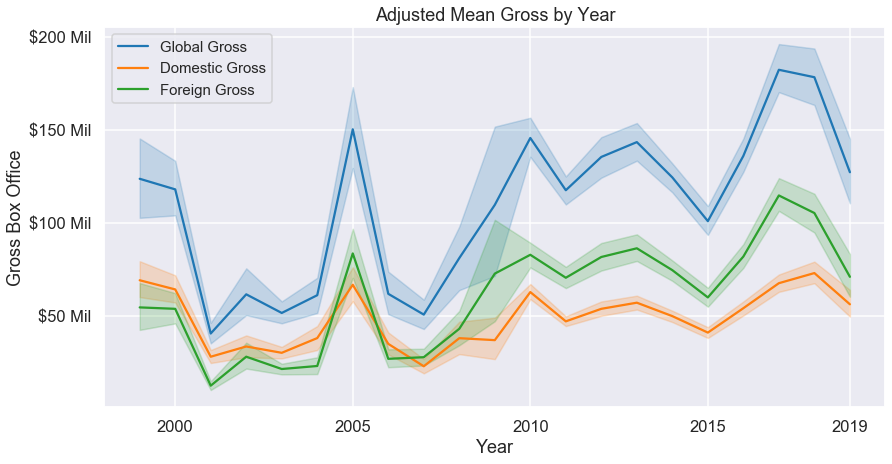

In [50]:
#Plot the average gross per year.
fig, ax = plt.subplots(figsize=(14,7))
plt.title('Adjusted Mean Gross by Year')
plt.yticks(ticks=[50000000,100000000,150000000,200000000], 
           labels=['$50 Mil','$100 Mil', 
                   '$150 Mil', '$200 Mil'])
plt.xticks(ticks=[2000,2005,2010,2015,2019])
sns.lineplot(y='adj_wide_gross', x='year', data=trends, 
             label='Global Gross', ax=ax, 
             palette='colorblind')
sns.lineplot(y='adj_dom_gross', x='year', data=trends, 
             label='Domestic Gross', ax=ax, 
             palette='colorblind')
sns.lineplot(y='adj_frn_gross', x='year', data=trends, 
             label='Foreign Gross', ax=ax, 
             palette='colorblind')
ax.set(xlabel='Year', ylabel='Gross Box Office')
ax.legend(ncol=1, loc="upper left", 
          frameon=True, fontsize='small')
plt.savefig('figures/trends.png', bbox_inches='tight', transparent=True);

In [8]:
get_prop([1999,2000,2001,2002,2003])
get_prop([2004,2005,2006,2007,2008])
get_prop([2009,2010,2011,2012,2013])
get_prop([2014,2015,2016,2017,2018])

1999-2003 proportion wide gross from frn box: 0.43
2004-2008 proportion wide gross from frn box: 0.51
2009-2013 proportion wide gross from frn box: 0.6
2014-2018 proportion wide gross from frn box: 0.6


### Defining Success

###### Profits

The median profit is: $14787479.62
The mean profit is: $95689612.93


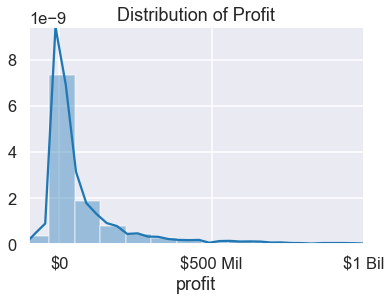

In [9]:
#Group the dataframe by movie.
prodf = movies[['title','profit']].groupby('title').median()
plt.title('Distribution of Profit')
sns.distplot(prodf['profit'])
plt.xlim(-100000000, 1000000000)
plt.xticks(ticks=[0, 500000000,1000000000], 
           labels=['$0', '$500 Mil', '$1 Bil'])
plt.savefig('figures/distprofit.png');

print('The median profit is: $' 
      + str(round(prodf['profit'].median(),2)))
print('The mean profit is: $' 
      + str(round(prodf['profit'].mean(),2)))

This distribution is showing some major outliers dragging the central tendency toward the huge profits even though there are many films that made zero dollars. 

In [10]:
#Gather quartile data on profit.
print('Top 25% of films made more than: ' 
      + str(round(prodf['profit'].quantile(.75),2)))
print('Top 50% of films made more than: ' 
      + str(round(prodf['profit'].quantile(.5),2)))
print('Top 75% of films made more than: ' 
      + str(round(prodf['profit'].quantile(.25),2)))
print('100% of films made more than: ' 
      + str(round(prodf['profit'].quantile(0),2)))

Top 25% of films made more than: 92843958.34
Top 50% of films made more than: 14787479.62
Top 75% of films made more than: -2402409.2
100% of films made more than: -200237650.0


In [11]:
#Print the total(%) of films that fall into each category.
total_films = len(prodf)
print('Films with over $100 Million Dollars Profit: ' 
      +str(len(prodf[prodf['profit']>100000000]))
      +'('+str(round((len(prodf[
          prodf['profit']>100000000
      ])/total_films)*100,2))+'%)')
print('Films with over $15 Million Dollars Profit: ' 
      +str(len((prodf[(prodf['profit']>15000000)
                      & (prodf['profit']<=100000000)])))
      +'('+str(round((len(prodf[(
          prodf['profit']>15000000)
          &(prodf['profit']<=100000000)
      ])/total_films)*100,2))+'%)')
print('Films with less than $15 Million Dollars Profit: ' 
      +str(len((prodf[(prodf['profit']>0) 
                      & (prodf['profit']<=15000000)])))
      +'('+str(round((len(prodf[(
          prodf['profit']>0) 
          &(prodf['profit']<=15000000)
      ])/total_films)*100,2))+'%)')
print('Films that lost money: '
      +str(len(prodf[prodf['profit']<0]))
      +'('+str(round((len(prodf[
          prodf['profit']<0
      ])/total_films)*100, 2))+'%)')

Films with over $100 Million Dollars Profit: 514(24.18%)
Films with over $15 Million Dollars Profit: 545(25.63%)
Films with less than $15 Million Dollars Profit: 276(12.98%)
Films that lost money: 791(37.21%)


To split the data into categories I'll define 'hit' to mean any movie that makes over 15 million dollars and 'blockbuster' to mean movies that make over 100 million dollars. Any film that makes less than 15 million dollars can be called a 'flop', and any film that loses money can be defined a 'failure'.

In [12]:
#Create a categorical column for each success level.
prodf.loc[prodf['profit']>100000000,
           'success']='Blockbuster (> $100 mil profit)'
prodf.loc[(prodf['profit']>15000000) 
           & (prodf['profit']<100000000), 
           'success']='Hit (> $15 mil profit)'
prodf.loc[(prodf['profit']>0) 
           & (prodf['profit']<15000000), 
           'success']='Flop (< $15 mil profit)'
prodf.loc[prodf['profit']<0, 
           'success']='Failure (< $0 profit)'

#Test to make sure the column holds the information we want.
prodf['success'].value_counts()

Failure (< $0 profit)              791
Hit (> $15 mil profit)             545
Blockbuster (> $100 mil profit)    514
Flop (< $15 mil profit)            276
Name: success, dtype: int64

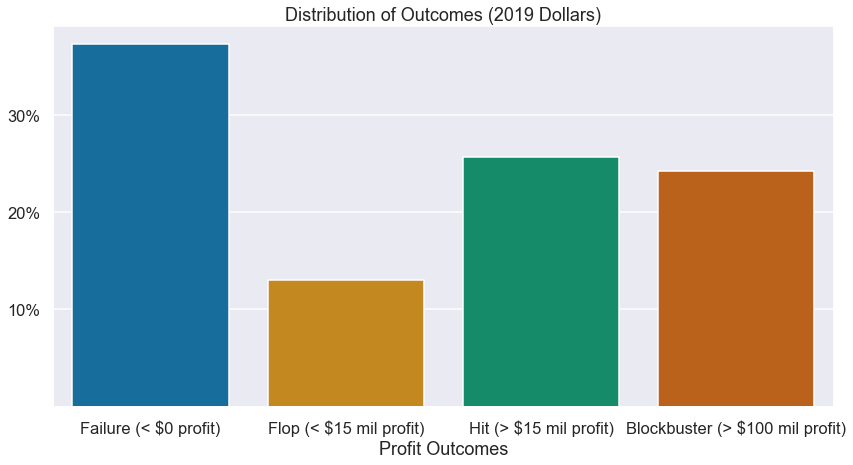

In [51]:
#Check the distribution with a visualization.
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(14,7))
plt.title('Distribution of Outcomes (2019 Dollars)')
sns.countplot(x=prodf['success'], data=prodf, 
              order=['Failure (< $0 profit)',
                     'Flop (< $15 mil profit)',
                     'Hit (> $15 mil profit)',
                     'Blockbuster (> $100 mil profit)'],
              palette='colorblind')
ax.set_yticks(ticks=[.1*2126, .2*2126, .3*2126])
ax.set_yticklabels(labels=['10%','20%', '30%'])
ax.set(xlabel='Profit Outcomes', ylabel='')
plt.savefig('figures/distoutcomes.png', bbox_inches='tight', transparent=True);

So the distribution I saw in the histogram of profits can be explained by the wide spread of profits in the top half of the sample, compared to the bunching around 0 in the bottom half. Using categorical data paints a much clearer picture of the data. I can use the 15 million dollar threshold to differentiate between success and failure, while targeting profits of over 100 million.

###### Audience Rating

To determine what our definition of success will be when it comes to audience rating, we have to answer two questions at once:

- Do postive ratings lead to bigger box office returns?
- What rating threshold should we aim for? 

To answer this question we'll compare worldwide box office to the average rating of the films.

Mean: 6.24
Median: 6.3
Max: 9.1
Min: 1.6


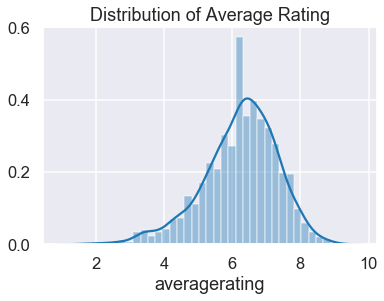

In [14]:
#Create a dataframe with the necessary data.
aud_rate = movies[['title', 'averagerating', 
                   'adj_wide_gross', 
                   'numvotes']].groupby('title').mean()

#Plot the distribution of ratings.
plt.title('Distribution of Average Rating')
sns.distplot(aud_rate['averagerating'])
plt.savefig('figures/distavgrating.png');

#Get measures of central tendency.
print('Mean: '+ str(round(aud_rate['averagerating'].mean(),2)))
print('Median: '+ str(round(aud_rate['averagerating'].median(),2)))
print('Max: '+ str(round(aud_rate['averagerating'].max(),2)))
print('Min: '+ str(round(aud_rate['averagerating'].min(),2)))

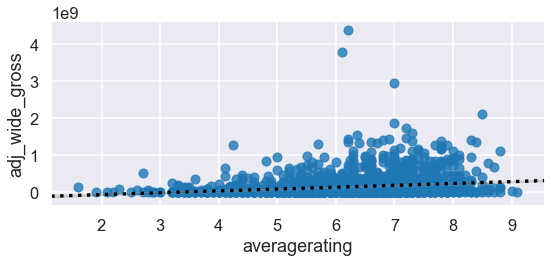

In [15]:
sns.lmplot(x='averagerating', y='adj_wide_gross', 
            data=aud_rate, aspect=2, height=4,
           line_kws={'color':'black', 'linestyle':':'})
plt.savefig('figures/scatavgrat.png');

There appears to be a hint of positive correlation suggesting that higher quality films make more money. Next I'll look at quantile data to separate the ratings into 5 quality levels so we can look at the data categorically.

In [16]:
#Get the average ratings for quantiles of the data
print('Top 20% of films average rating > ' 
      + str(round(aud_rate['averagerating'].quantile(.8),2)))
print('Top 40% of films average rating > ' 
      + str(round(aud_rate['averagerating'].quantile(.6),2)))
print('Top 60% of films average rating > ' 
      + str(round(aud_rate['averagerating'].quantile(.4),2)))
print('Top 80% of films average rating > ' 
      + str(round(aud_rate['averagerating'].quantile(.2),2)))
print('100% of films average rating > ' 
      + str(round(aud_rate['averagerating'].quantile(0),2)))

Top 20% of films average rating > 7.1
Top 40% of films average rating > 6.6
Top 60% of films average rating > 6.1
Top 80% of films average rating > 5.4
100% of films average rating > 1.6


Next I'll plot the categorical data on a boxplot. I'll need to do this again later, so I can define a two functions one that can group the data into 5 bins of numerical data and another that can create a boxplot. 

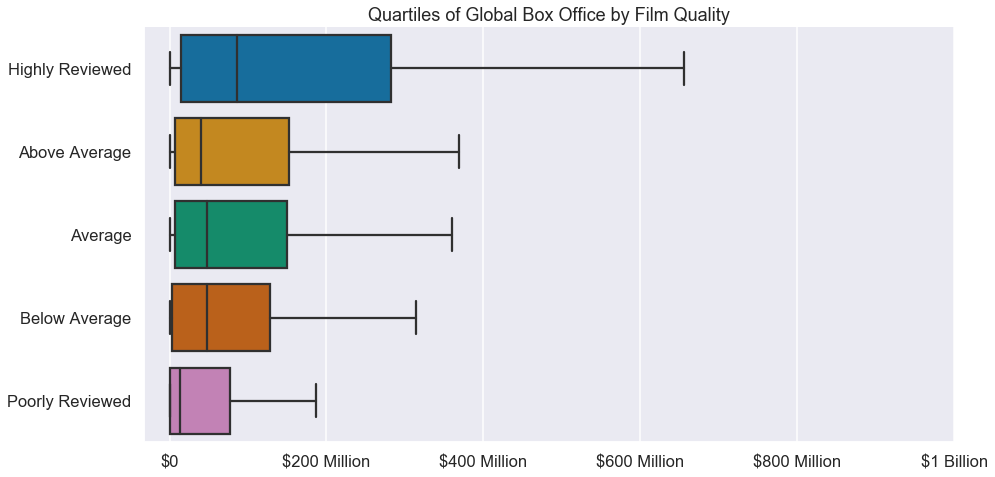

In [17]:
#Name ratings bins.
ratings_bins = ['Highly Reviewed', 'Above Average', 
                'Average', 'Below Average','Poorly Reviewed']

#Create the plot.
cat_box(aud_rate, 'averagerating', 'adj_wide_gross', 
        'Film Quality', 'Global Box Office', 
        [0,200000000, 400000000, 600000000, 
         800000000, 1000000000], 
        ['$0','$200 Million', '$400 Million', 
         '$600 Million', '$800 Million', '$1 Billion'],
        bin_names=ratings_bins, 
        save=(False,0))

Unsurprisingly, highly reviewed films make more in global gross. and because of the bunching of values in the middle of the distribution above average and average films make roughly the same. 

###### Popular Movies 

First I'll take a slice of the data for films that have alot of interest. I'll define that as movies that made more than $0 and crossed a threshold of number of voters for the ratings. 

Mean: 80666.36
Median: 80666.36
25% films received at least 92676.75 votes.
50% films received at least 24903.5 votes.
75% films received at least 1502.67 votes.
90% films received at least 100.0 votes.


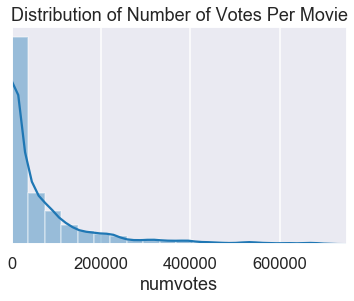

In [18]:
#Investigate the distribution of number of votes.
plt.title('Distribution of Number of Votes Per Movie')
sns.distplot(aud_rate['numvotes'])
plt.yticks(ticks=[], labels=[])
plt.xlim(0,750000)
plt.savefig('figures/distnumvote');
print('Mean: '+ str(round(aud_rate['numvotes'].mean(),2)))
print('Median: '+ str(round(aud_rate['numvotes'].mean(),2)))
print('25% films received at least {} votes.'.format(
    str(round(aud_rate['numvotes'].quantile(.75),2))))
print('50% films received at least {} votes.'.format(
    str(round(aud_rate['numvotes'].quantile(.5),2)))
     )
print('75% films received at least {} votes.'.format(
    str(round(aud_rate['numvotes'].quantile(.25),2)))
     )
print('90% films received at least {} votes.'.format(
    str(round(aud_rate['numvotes'].quantile(.10),2)))
     )

Mean: 6.57
Median: 6.6
Max: 8.8
Min: 1.6


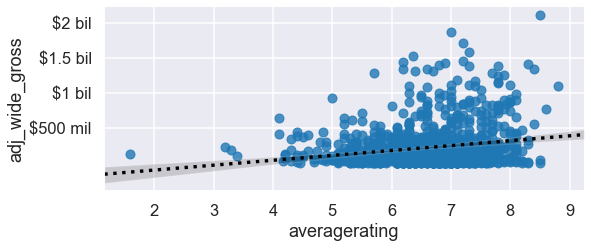

In [19]:
#Slice a new dataframe.
pop_movies = aud_rate.loc[(aud_rate.loc[:,'numvotes']>=25000) 
                          &(aud_rate.loc[:,'adj_wide_gross']>0)]

print('Mean: '+ str(round(pop_movies['averagerating']
                          .mean(),2)))
print('Median: '+ str(round(pop_movies['averagerating']
                            .median(),2)))
print('Max: '+ str(round(pop_movies['averagerating']
                         .max(),2)))
print('Min: '+ str(round(pop_movies['averagerating']
                         .min(),2)))

#Plot the data in a scatterplot
sns.lmplot(x='averagerating', y='adj_wide_gross', 
            data=pop_movies, height=4, aspect=2,
           line_kws={'color':'black', 'linestyle':':'})
plt.yticks(ticks= [500000000, 1000000000, 
                   1500000000, 2000000000],
           labels= ['$500 mil', '$1 bil', '$1.5 bil',
                    '$2 bil'])
plt.savefig('figures/popqualscat');

C:\Users\Shawn\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


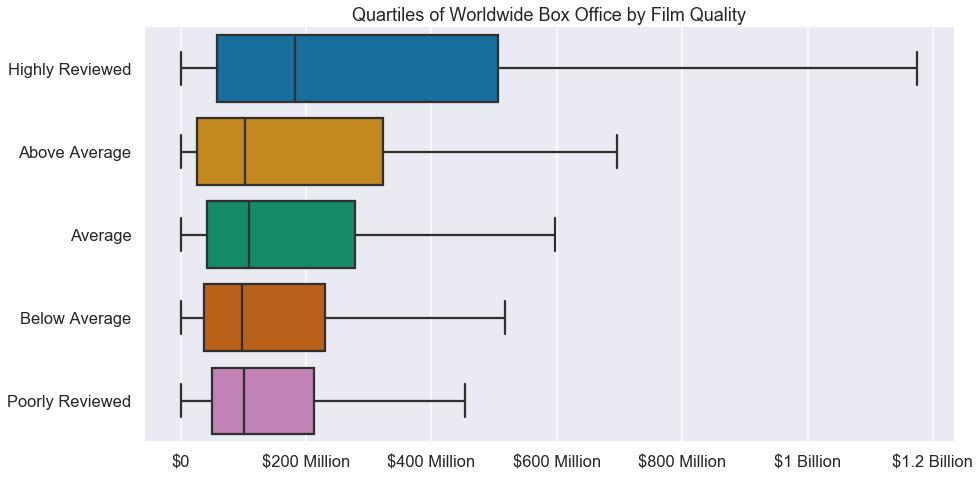

In [52]:
cat_box(pop_movies, 'averagerating', 'adj_wide_gross', 
        'Film Quality', 'Worldwide Box Office', 
        [0,200000000, 400000000, 600000000, 
         800000000, 1000000000, 1200000000], 
        ['$0','$200 Million', '$400 Million', 
         '$600 Million', '$800 Million', 
         '$1 Billion', '$1.2 Billion'],
        bin_names=ratings_bins,
        save=(True, 'figures/popcatbox'))

The pattern we saw above is even more apparent with popular films. We can use a threshold of above average ratings to define success.

# Background Conclusion

The movie industry is growing, especially due to the increase in foreign box office returns. To determine success for the remainder of the analysis we will be using the thresholds described above and summarized here.

###### Profit

- Blockbuster-  > 100 million dollars profit
- Hit-          > 10 million dollars profit
- Flop-         < 10 million dollars profit
- Failure-      < 0 dollars profit

###### Quality

- Highly Reviewed-  average rating > 7.1
- Above Average-    average rating > 6.6
- Average-          average rating > 6.1
- Below Average-    average rating > 5.4
- Poorly Reviewed-  average rating > 1.6



# Question 1

#### How much money should be invested?
##### 1a. Does higher production budget lead to higher rating?
##### 1b. Which investment level leads to the highest profits?
##### 1c. What amount of risk come with different investment levels?

For this analysis I will again be using audience rating, but this time I will also be analyzing profit. Both of these factors will be compared to production costs so I can reccomend a target investment amount per film. 

Mean: 45763179.17
Median: 22965043.25


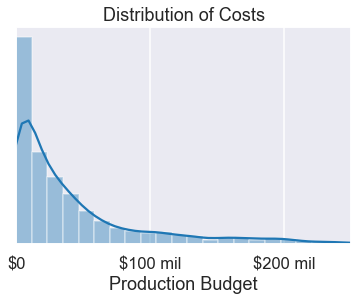

In [21]:
#Slice a new dataframe.
costs = movies[['title', 'profit', 
                'averagerating', 'adj_prod_budg', 
                'adj_wide_gross']].groupby('title').mean()

sns.distplot(costs['adj_prod_budg'])
plt.yticks(ticks=[], labels=[])
plt.xticks(ticks=[0, 100000000, 200000000],
           labels=['$0', '$100 mil', '$200 mil'])
plt.xlabel('Production Budget')
plt.xlim(0,250000000)
plt.title('Distribution of Costs')
plt.savefig('figures/distcosts.png');
print('Mean: '+ str(round(costs['adj_prod_budg'].mean(),2)))
print('Median: '+ str(round(costs['adj_prod_budg'].median(),2)))

As with above it will be useful to divide these into categories to make analysis more comprehensible.

In [22]:
quant1 = round(costs['adj_prod_budg'].quantile(.8),2)
quant2 = round(costs['adj_prod_budg'].quantile(.6),2)
quant3 = round(costs['adj_prod_budg'].quantile(.4),2)
quant4 = round(costs['adj_prod_budg'].quantile(.2),2)

print('The top 20% of movies by cost spend at least ${}'
      .format(quant1))
print('The top 40% of movies by cost spend at least ${}'
      .format(quant2))
print('The top 60% of movies by cost spend at least ${}'
      .format(quant3))
print('The top 80% of movies by cost spend at least ${}'
      .format(quant4))

The top 20% of movies by cost spend at least $71490309.78
The top 40% of movies by cost spend at least $32843038.68
The top 60% of movies by cost spend at least $15104303.98
The top 80% of movies by cost spend at least $4094817.87


We now have five different levels of cost that we can use to categorize data. We can name them 'Huge', 'Big, 'Average', 'Small', and 'Tiny'.

In [23]:
cost_bins = ['Huge', 'Big', 'Average', 'Small', 'Tiny']

### Question 1a

When it comes to production budget, does spending more lead to a higher quality movie? To answer this I'll do a simple scatter plot and observe the distibution of the values:

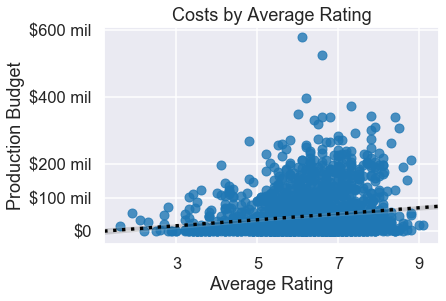

In [24]:
sns.regplot(y='adj_prod_budg', x='averagerating', data=costs,
           line_kws={'color':'black', 'linestyle':':'})
plt.xticks(ticks=[3,5,7,9], labels=[3,5,7,9])
plt.xlabel('Average Rating')
plt.yticks(ticks=[0, 100000000, 200000000, 400000000,
                 600000000],
           labels=['$0', '$100 mil', '$200 mil', '$400 mil',
                  '$600 mil'])
plt.ylabel('Production Budget')
plt.title('Costs by Average Rating')
plt.savefig('figures/scatcostsVrate.png');

There seems to be a slight positive correlation. Now I'll look at how the data looks in categorical form:

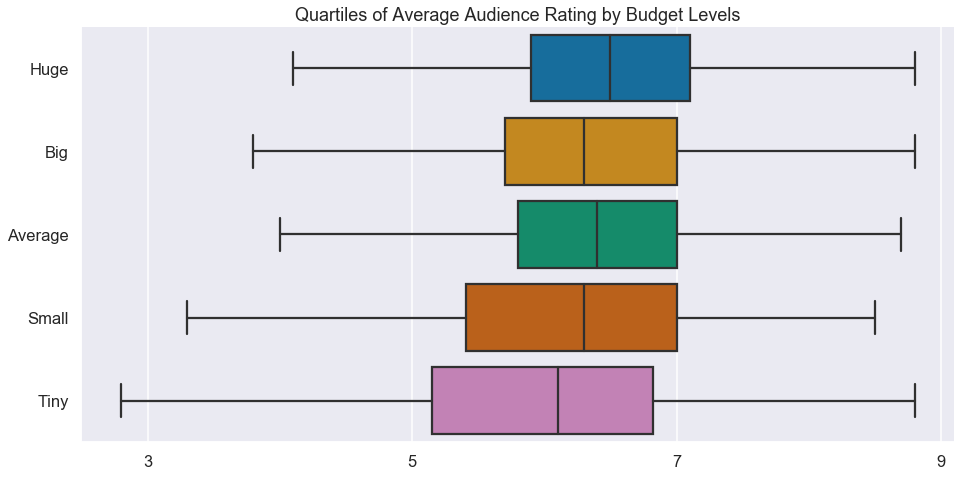

In [25]:
cat_box(costs, 'adj_prod_budg', 'averagerating', 
        'Budget Levels', 'Average Audience Rating',
        [3,5,7,9],[3,5,7,9], bin_names=cost_bins, 
        save=(True,'figures/boxrateOFcost.png'))

So, investment in any budget range can result in a high quality film. Looking at the left whiskers of the boxes though, it seems that huge bugdets may be a more reliable investment.

### Question 1b

Is it better to release several films with a given budget or throw it all into one big blockbuster? To answer this I'll assess the scatter plot of production budget by profit:

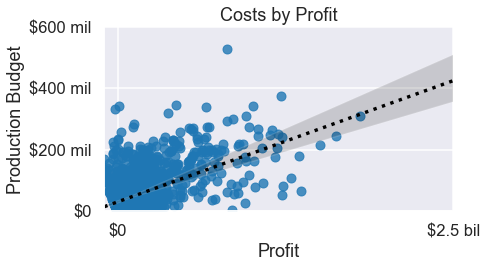

In [26]:
sns.lmplot(y='adj_prod_budg', x='profit', data=costs,
           height=4, aspect=1.5, 
           line_kws={'color':'black', 'linestyle':':'})
plt.yticks(ticks=[0, 200000000, 400000000, 600000000],
           labels=['$0', '$200 mil', '$400 mil', '$600 mil'])
plt.xticks(ticks=[0, 2500000000],
           labels=['$0', '$2.5 bil'])
plt.xlim(-100000000,2500000000)
plt.ylim(0,600000000)
plt.title('Costs by Profit')
plt.ylabel('Production Budget')
plt.xlabel('Profit')
plt.savefig('figures/scatcostsVprofit.png');

The scatterplot indicates that there is a positive correlation, let's take a look at the data catagorically:

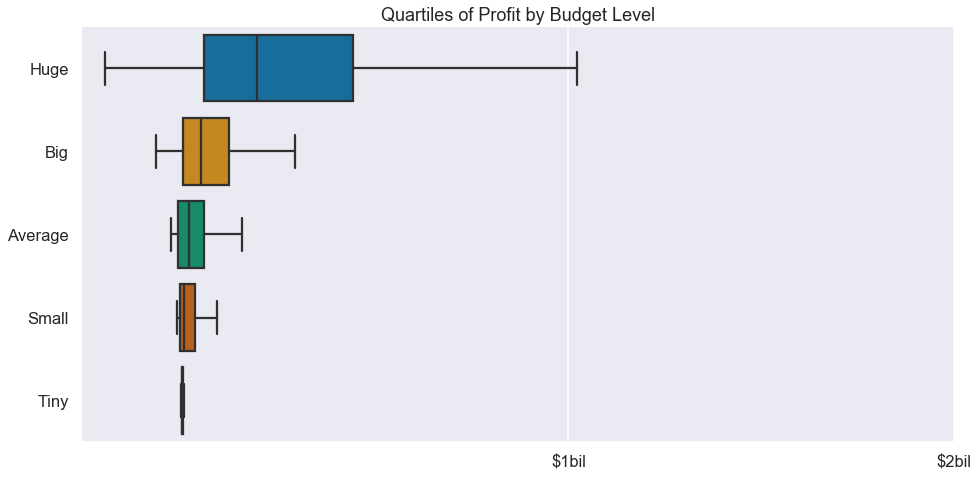

In [27]:
cat_box(costs, 'adj_prod_budg', 'profit', 'Budget Level',
        'Profit', [1000000000, 2000000000],
        ['$1bil', '$2bil'], bin_names=cost_bins,
       save=(True,'figures/boxprofitBybudg.png'))

### Question 1c

To understand the risks associated with a film I'll calculate the expected return on investment of a film.

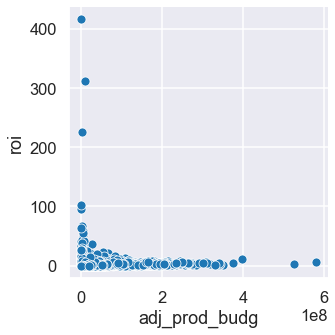

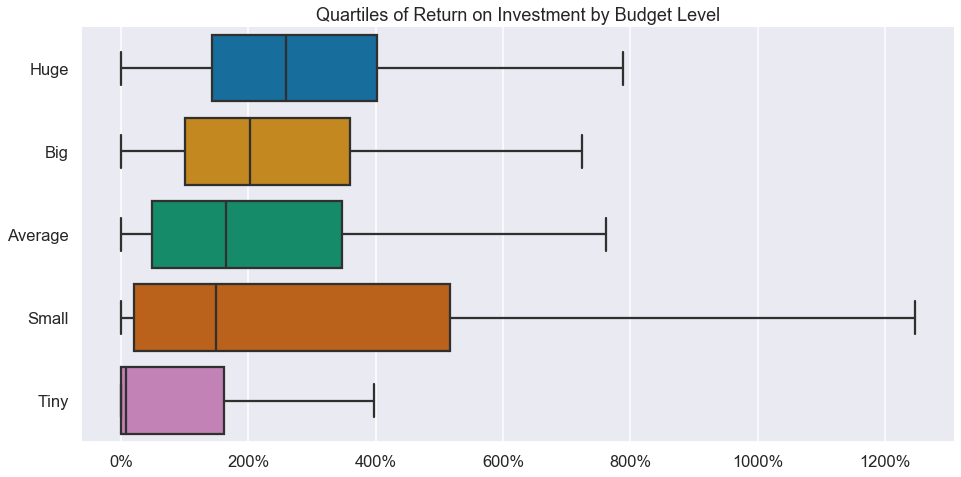

In [28]:
costs['roi']= (costs['adj_wide_gross']/costs['adj_prod_budg'])

sns.relplot(x='adj_prod_budg', y='roi', data= costs);

cat_box(costs, 'adj_prod_budg', 'roi', 'Budget Level', 
        'Return on Investment', [0, 2, 4, 6, 8, 10, 12],
        ['0%', '200%', '400%', '600%', '800%', '1000%',
        '1200%'],
        bin_names=cost_bins, 
        save=(True,'figures/boxroiBYcostnofliers.png'))

Taken together these two plots tell a strange story. Because of the small budgets involved it seems like some outliers are skewing the data for small budget films. Let's remove outliers from the boxplot.

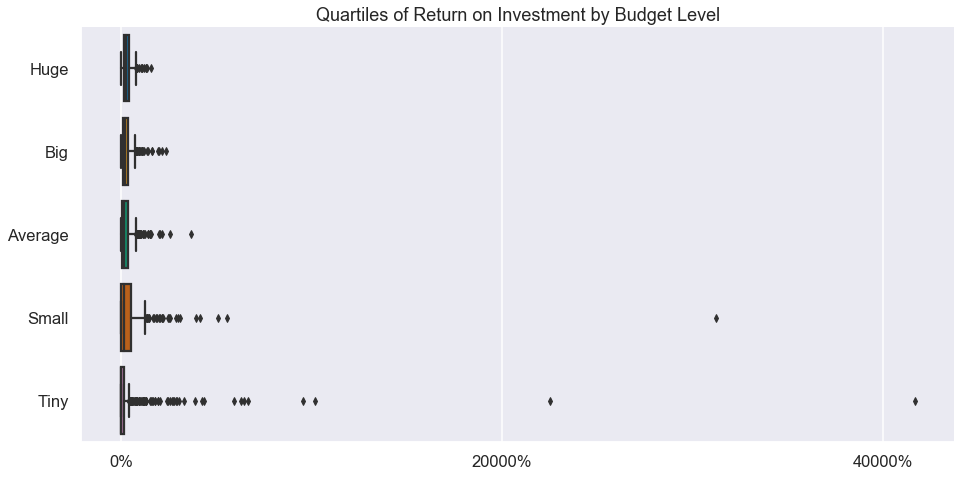

In [29]:
cat_box(costs, 'adj_prod_budg', 'roi', 'Budget Level', 
        'Return on Investment', [0, 200, 400],
        ['0%', '20000%', '40000%'],
        bin_names=cost_bins, 
        save=(True,'figures/boxroiBYcostWithfliers.png'),
        omitfliers=False)

Using return on investment won't be an effective measure of success because of these outliers. I'll use profit to calculate expected profit.

First I'll calculate details for movies that atleast made money.

Overall Success Rate is: 0.63


,winrate,lossrate
Budget Level,,
Huge,0.88,0.12
Big,0.75,0.25
Average,0.61,0.39
Small,0.57,0.43
Tiny,0.33,0.67


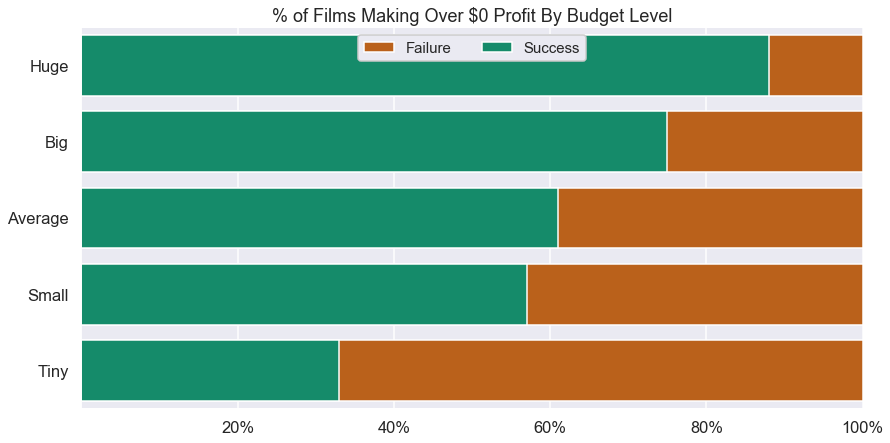

In [30]:
simple_rate(costs,'Budget Level','Budget Level', 
            'profit', 0, save=(True, 'figures/profitovr0.png'))

Next, let's check the success rate for movies making more than 10 million dollars.

Overall Success Rate is: 0.5


,winrate,lossrate
Budget Level,,
Huge,0.84,0.16
Big,0.67,0.33
Average,0.52,0.48
Small,0.38,0.62
Tiny,0.09,0.91


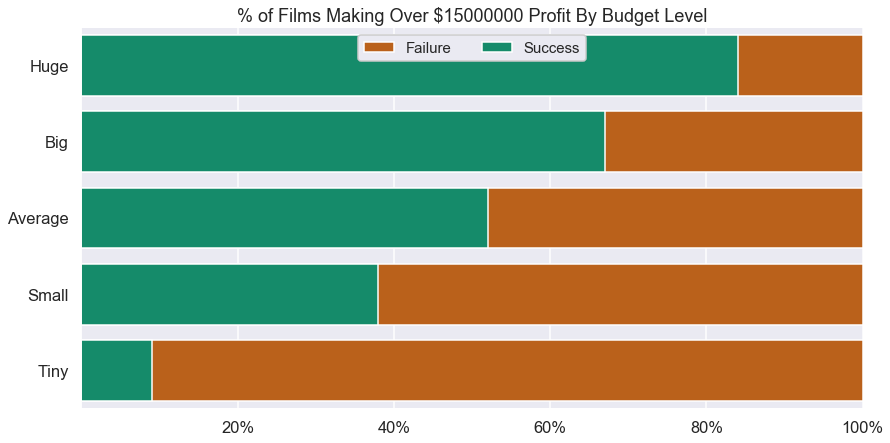

In [31]:
simple_rate(costs,'Budget Level','Budget Level', 
            'profit', 15000000, 
            save=(True, 'figures/profitovr15.png'))

Now I can analyze budget levels using the tiered rates.

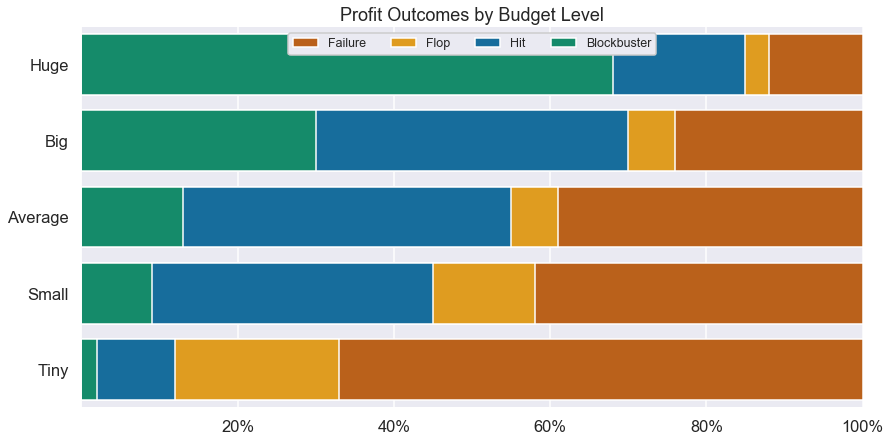

In [32]:
tiered_rates(costs, 'Budget Level', 'Budget Level',
            save=(True,'figures/tierBYbudg.png'))

To understand the amount of risk best I'll calculate expected profits by multiplying median loss and gain with the simple % chance that kind of movie made or lost money. 

,winrate,lossrate,expectedprofit
Budget Level,,,
Huge,0.88,0.12,2.056064e+08
Big,0.75,0.25,5.162169e+07
Average,0.61,0.39,2.367492e+07
Small,0.57,0.43,1.292532e+07
Tiny,0.33,0.67,8.277834e+05


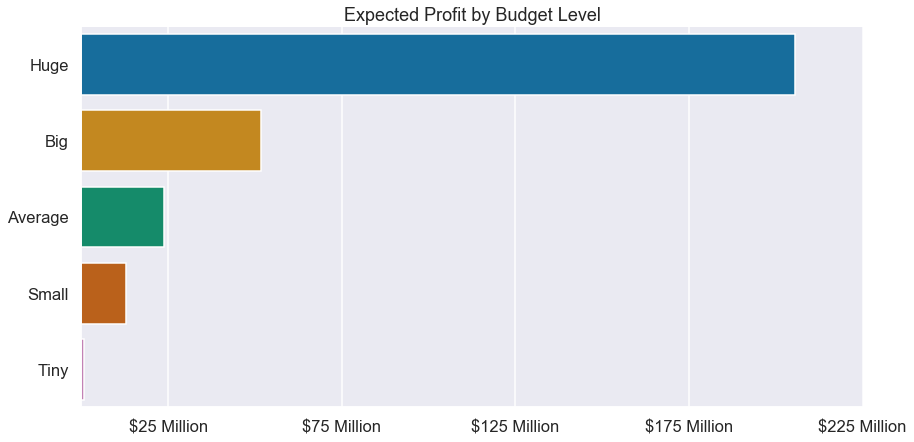

In [33]:
calculate_expected(costs, 'Budget Level', 'Budget Level', 
                   show_rates=False, 
                   save=(True,'figures/expbybudgt.png'))

# Question 1 Conclusion

The budget level with the highest potential for profit is huge, somewhat counterintuitively it also has the lowest risk. Aside from a few outliers in the smaller budget categories this holds true for return on investment. 

Finally, over the course of many films blockbusters provide the highest expected profit by far. Given the potential risks of failure however, and the fact that big budget films still perform fairly well, my recommendation is that we invest in films with production budgets no less than $50 million dollars. 

# Question 2

#### What kind of films should we produce?
- Once we know what kind of film, when should we release it?

Now our analysis will shift to analysing genre. Because of the fact that a film can have more than one genre the sample size will be expanded. I can split each film into an entry for each genre that it represents.

In [34]:
#Split the genre entry into a list of strings.
genre_data = []
for genres in movies['genres']:
    genre_data.append(genres.replace(',',' ').split())

#Create three lists with the 1st, 2nd, and 3rd genre.
genre1 = []
genre2 = []
genre3 = []
for index in range(0, len(genre_data)):
    if len(genre_data[index])==3:
        genre1.append(genre_data[index][0])
        genre2.append(genre_data[index][1])
        genre3.append(genre_data[index][2])
    elif len(genre_data[index])==2:
        genre1.append(genre_data[index][0])
        genre2.append(genre_data[index][1])
        genre3.append('None')
    else:
        genre1.append(genre_data[index][0])
        genre2.append('None')
        genre3.append('None')

#Assign each list to a column and drop the original column.        
movies['genre1'] = genre1
movies['genre2'] = genre2
movies['genre3'] = genre3
movies.drop('genres', axis=1, inplace=True)

#Slice the data we need into three separate dataframes.
genre1df = movies.loc[:,['genre1', 'profit', 'month', 
                         'adj_prod_budg', 'title', 
                         'adj_dom_gross', 
                         'adj_frn_gross', 'adj_wide_gross']]
genre2df = movies.loc[:,['genre2', 'profit', 'month', 
                         'adj_prod_budg', 'title', 
                         'adj_dom_gross', 
                         'adj_frn_gross', 'adj_wide_gross']]
genre3df = movies.loc[:,['genre3', 'profit', 'month', 
                         'adj_prod_budg', 'title', 
                         'adj_dom_gross', 
                         'adj_frn_gross', 'adj_wide_gross']]

#Rename the genre columns. 
genre1df.rename(columns={'genre1':'genre'}, inplace=True)
genre2df.rename(columns={'genre2':'genre'}, inplace=True)
genre3df.rename(columns={'genre3':'genre'}, inplace=True)

#Concatenate the dataframes and slice the None values away.
genre = pd.concat([genre1df,genre2df,genre3df], sort=False)
genre = genre[genre['genre']!='None']

#Drop the duplicated rows.
genre = genre.drop_duplicates()

display(genre.head())
print('\n There are {} unique genres. They are:'
      .format(genre['genre'].nunique()))
display(genre['genre'].unique())

,genre,profit,month,adj_prod_budg,title,adj_dom_gross,adj_frn_gross,adj_wide_gross
0,Crime,-1.698778e+06,Nov,1698777.86,#Horror,0.00,0.00,0.000000e+00
10,Drama,1.133906e+08,Mar,5489136.17,10 Cloverfield Lane,79134679.45,39745103.75,1.188798e+08
20,Drama,-1.357367e+07,Nov,13590222.90,10 Days in a Madhouse,16552.89,0.00,1.655289e+04
30,Action,-3.676262e+06,Mar,27298785.77,12 Rounds,16699614.52,6922909.28,2.362252e+07
39,Action,3.725972e+07,Jan,36106000.00,12 Strong,47267615.93,26098102.81,7.336572e+07



 There are 22 unique genres. They are:


array(['Crime', 'Drama', 'Action', 'Biography', 'Adventure', 'Horror',
       'Comedy', 'Documentary', 'Animation', 'Family', 'Romance',
       'Fantasy', 'Sci-Fi', 'Thriller', 'Music', 'Mystery', 'Western',
       'Musical', 'War', 'Sport', 'History', 'News'], dtype=object)

In [35]:
genre['genre'].value_counts()

Drama          1196
Comedy          724
Action          598
Thriller        456
Adventure       443
Crime           349
Horror          334
Romance         300
Mystery         213
Sci-Fi          202
Biography       194
Documentary     194
Fantasy         169
Family          140
Animation       130
Music            72
History          69
Sport            60
War              38
Musical          22
Western          16
News              3
Name: genre, dtype: int64

With so many genres we may have trouble digesting the data. We can use our judgment to combine some genres together. To get down to 16 genres we can:

In [36]:
#Drop 'news' because there are so few entries.
genre.drop(genre[genre['genre']=='News'].index, inplace=True)

#Rename Western into Adventure.
genre.loc[genre['genre']=='Western', 'genre']='Adventure'

#Rename War to History.
genre.loc[genre['genre']=='War', 'genre']='History'

#Combine Mystery and Crime into Crime/Mystery.
genre.loc[genre['genre']=='Mystery', 'genre']='Crime/Mystery'
genre.loc[genre['genre']=='Crime', 'genre']='Crime/Mystery'

#Combine Musical and Music into Musical/Music.
genre.loc[genre['genre']=='Musical', 'genre']='Musical/Music'
genre.loc[genre['genre']=='Music', 'genre']='Musical/Music'

#Combine History and Biography into History/Biography.
genre.loc[genre['genre']=='History', 
          'genre']='History/Biography'
genre.loc[genre['genre']=='Biography', 
          'genre']='History/Biography'

genre['genre'].value_counts()

Drama                1195
Comedy                724
Action                598
Crime/Mystery         562
Adventure             459
Thriller              456
Horror                334
History/Biography     301
Romance               300
Sci-Fi                202
Documentary           191
Fantasy               169
Family                140
Animation             130
Musical/Music          94
Sport                  60
Name: genre, dtype: int64

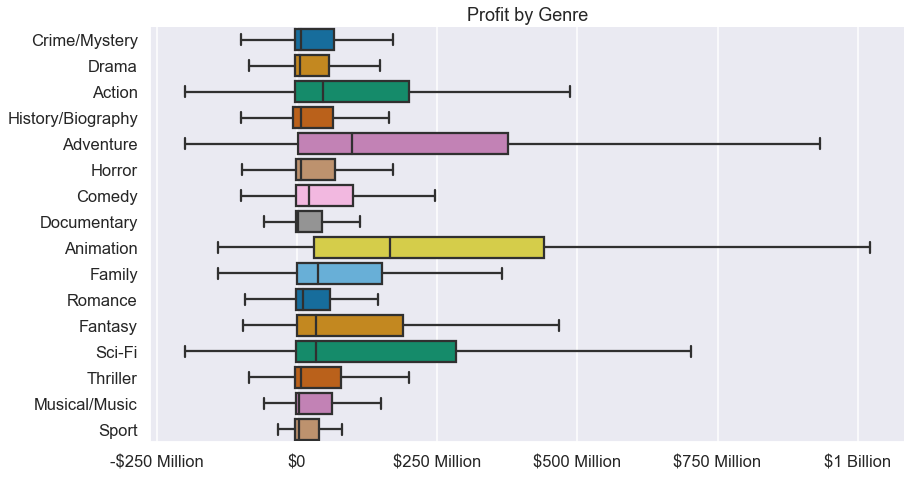

In [37]:
sns.catplot(y='genre', x='profit', data=genre, 
            palette='colorblind', kind='box', 
            height=7, aspect=1.9, showfliers=False)
plt.title('Profit by Genre')
plt.ylabel('')
plt.xlabel('')
plt.xticks(ticks=[-250000000, 0, 250000000, 
                     500000000, 750000000, 1000000000],
           labels=['-$250 Million', '$0', '$250 Million', 
                   '$500 Million', '$750 Million', 
                   '$1 Billion']);
plt.savefig('figures/boxprofitBYgenre.png')

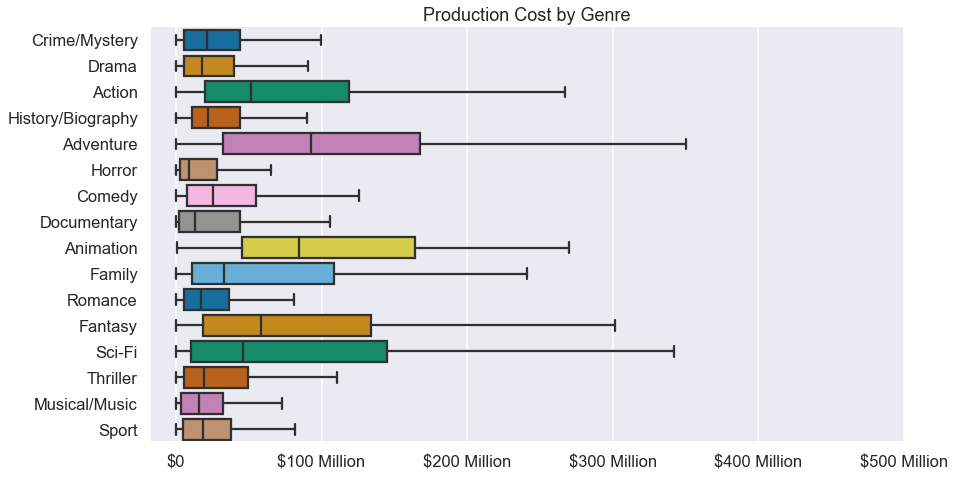

In [38]:
sns.catplot(y='genre', x='adj_prod_budg', data=genre, 
            palette='colorblind', kind='box', 
            height=7, aspect=1.9, showfliers=False)
plt.title('Production Cost by Genre')
plt.ylabel('')
plt.xlabel('')
plt.xticks(ticks=[0, 100000000, 200000000, 
                  300000000, 400000000, 500000000],
           labels=['$0', '$100 Million', '$200 Million',
                   '$300 Million', '$400 Million', 
                   '$500 Million']);
plt.savefig('figures/boxcostBYgenre.png')

This gives an idea of what genres of movies perform well, as well as their average production budgets. Interestingly, animated and adventure movies stand out in both charts. 

As we saw above, performing well in foreign markets is crucial for a successful movie. So, I'll compare success of genres in domestic and foreign markets.

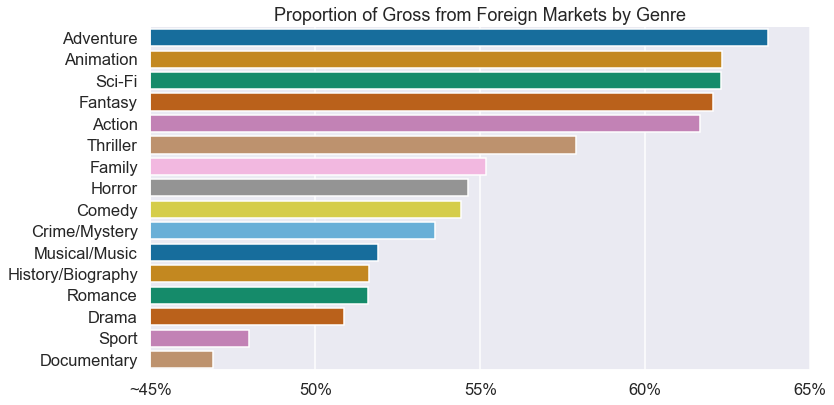

In [39]:
#Calculate profits that come from foreign markets.
genre['Genre']=genre['genre']
genre_grouped = genre.groupby('Genre').mean()
genre_grouped['genre']= sorted(genre['genre'].unique())
genre_grouped['prop_frn'] = (genre_grouped['adj_frn_gross']
                             /genre_grouped['adj_wide_gross'])
genre_grouped.sort_values('prop_frn', inplace=True,
                         ascending=False)
sns.catplot(y='genre', x='prop_frn', data=genre_grouped, 
            kind='bar', height=6, aspect=2, 
            palette='colorblind')
plt.xticks(ticks=[.45,.5,.55,.6,.65],
           labels=['~45%','50%','55%',
                   '60%','65%'])
plt.title('Proportion of Gross from Foreign Markets by Genre')
plt.xlabel('')
plt.ylabel('')
plt.xlim(.45,.65)
plt.savefig('figures/propfrnGenre.png');

###### success rate

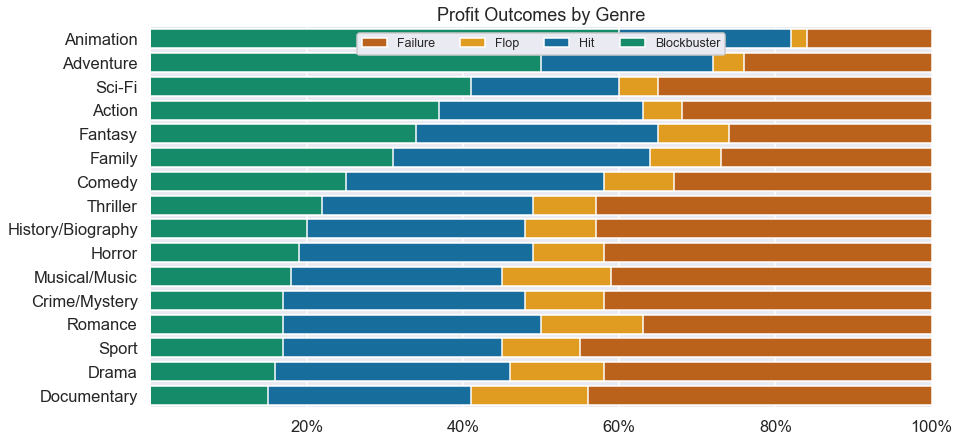

In [40]:
tiered_rates(genre, 'genre', 'Genre', 
             save=(True,'figures/profitoutcomesgenre'))

#### Expected Profit

Overall Success Rate is: 0.63


,winrate,lossrate
genre,,
Animation,0.83,0.17
Adventure,0.76,0.24
Fantasy,0.74,0.26
Family,0.73,0.27
Action,0.67,0.33
Comedy,0.67,0.33
Sci-Fi,0.65,0.35
Romance,0.63,0.37
Crime/Mystery,0.59,0.41


,winrate,lossrate,expectedprofit
genre,,,
Animation,0.83,0.17,1.981110e+08
Adventure,0.76,0.24,1.403508e+08
Sci-Fi,0.65,0.35,1.098254e+08
Action,0.67,0.33,7.947236e+07
Fantasy,0.74,0.26,6.179206e+07
Family,0.73,0.27,5.389938e+07
Comedy,0.67,0.33,4.228156e+07
Thriller,0.57,0.43,3.573543e+07
Horror,0.58,0.42,3.086551e+07


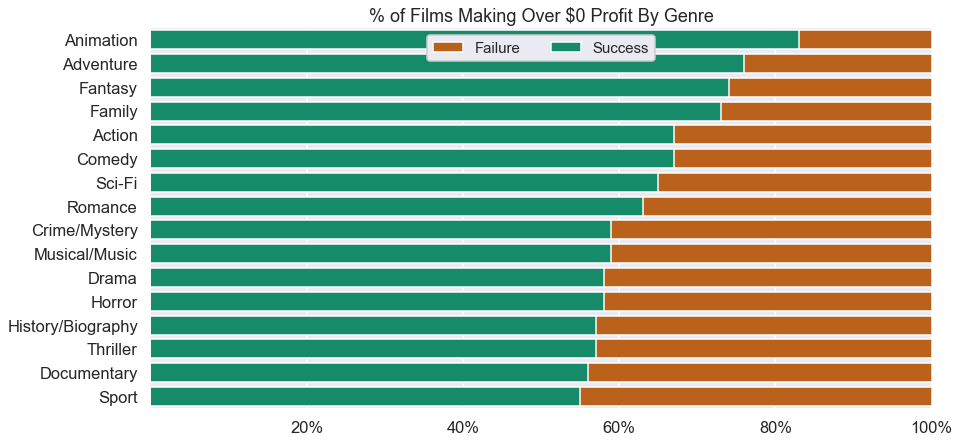

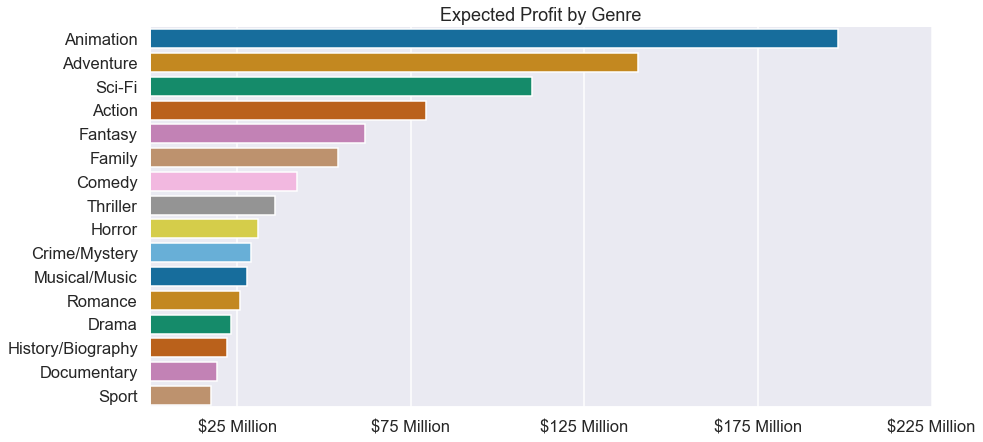

In [41]:
calculate_expected(genre, 'genre', 'Genre',
                  save=(True,'figures/expectedprofitgenre.png'))

# Question 2 Conclusion

There are eight genres that have an above average success rate (Animation, Adventure, Sci-Fi, Action, Fantasy, Family, Comedy, Romance). Of those eight, six have an expected profit above 50 million dollars (Animation, Adventure, Sci-Fi, Action, Fantasy, Family). Of those six, three have an expected profit above 100 million dollars (Animation, Adventure, Sci-Fi). 

My reccomendation is to invest in films from those top six genres, and preferably the top 3. In addition to having the highest expected profits, these genres also rank in the top 6 for production costs, which we already saw is correlated with success.  

# Question 3

##### When should we release the film?

To know when we should release a film we can analyze the month by month data. I'll split it into four seasons to compare which season is the best to release films overall. Then I'll zoom in to focus only on those films that satisfy the previously observed optimal conditions: 
1)having a production cost of over 50 million dollars and 
2)being of the Animation, Adventure, Sci-Fi, Action, Fantasy, or Family genres.

In [42]:
genre.loc[(genre['month']=='Jun')|
      (genre['month']=='Jul')|
      (genre['month']=='Aug'), 'season']='Summer'
genre.loc[(genre['month']=='Sep')|
      (genre['month']=='Oct')|
      (genre['month']=='Nov'), 'season']='Fall'
genre.loc[(genre['month']=='Dec')|
      (genre['month']=='Jan')|
      (genre['month']=='Feb'), 'season']='Winter'
genre.loc[(genre['month']=='Mar')|
          (genre['month']=='Apr')|
          (genre['month']=='May'), 'season']= 'Spring'

##### Analyze seasonal breakdown

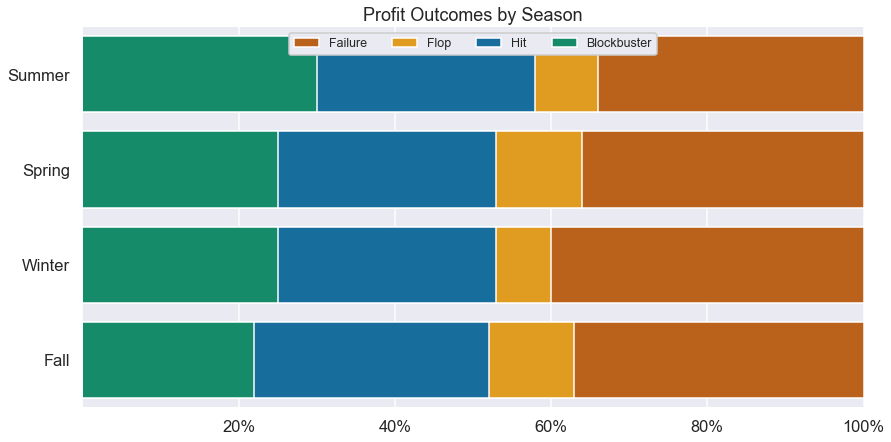

In [43]:
tiered_rates(genre, 'season', 'Season', 
             save=(True,'figures/tieredseasons.png'))

Overall Success Rate is: 0.63


,winrate,lossrate
season,,
Summer,0.67,0.33
Spring,0.64,0.36
Fall,0.63,0.37
Winter,0.60,0.40


,winrate,lossrate,expectedprofit
season,,,
Summer,0.67,0.33,5.199569e+07
Winter,0.60,0.40,4.180288e+07
Spring,0.64,0.36,3.988957e+07
Fall,0.63,0.37,3.592472e+07


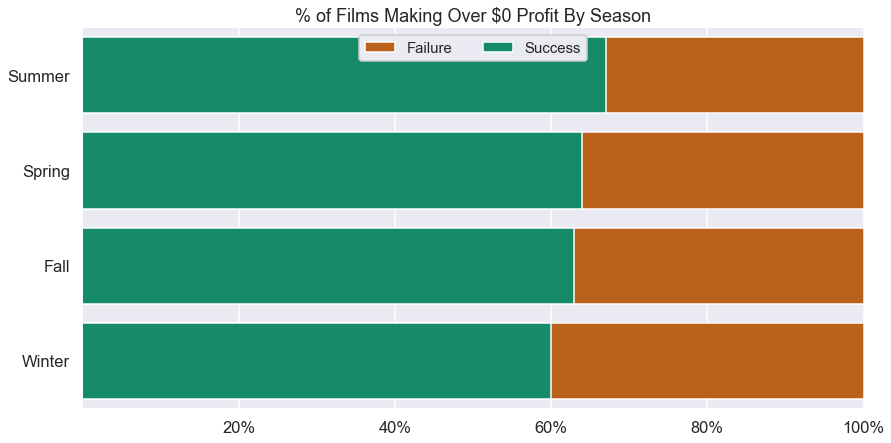

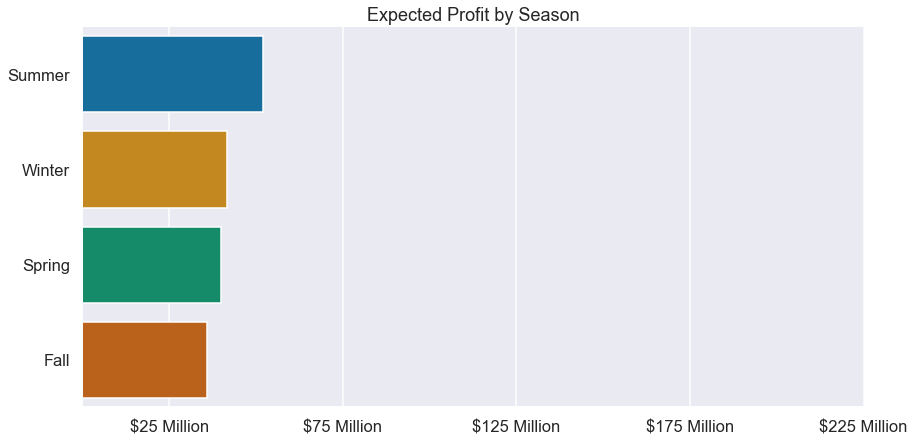

In [44]:
calculate_expected(genre, 'season', 'Season', show_rates=True)

##### Analyze Seasonal breakdown of target subgroup

In [45]:
#Isolate films with target budgets
target = genre[genre['adj_prod_budg']>50000000]

#Isolate films with target genres
target = target[(target['genre']=='Animation')|
                (target['genre']=='Adventure')|
                (target['genre']=='Sci-Fi')|
                (target['genre']=='Action')|
                (target['genre']=='Fantasy')|
                (target['genre']=='Family')]

print('There are '+str(target['title']
                       .nunique())
      +' films in the target subgroup') 

There are 457 films in the target subgroup


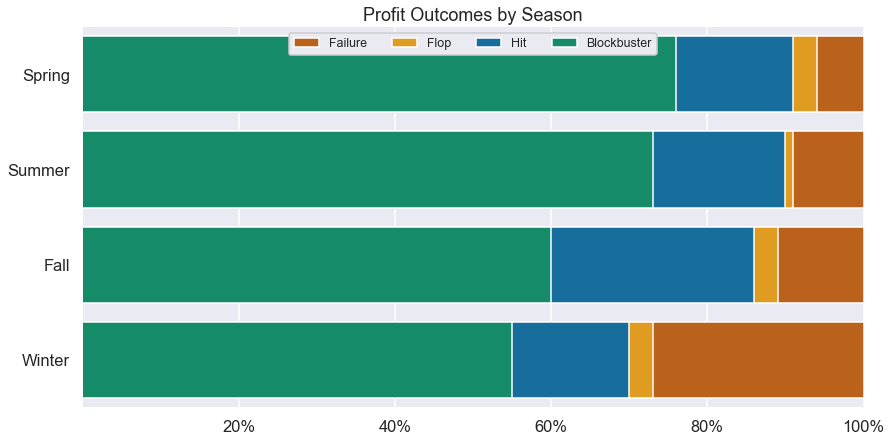

In [46]:
tiered_rates(target, 'season', 'Season',
            save=(True, 'figures/tiertargetseasons.png'))

Overall Success Rate is: 0.88


,winrate,lossrate
season,,
Spring,0.94,0.06
Summer,0.92,0.08
Fall,0.89,0.11
Winter,0.74,0.26


,winrate,lossrate,expectedprofit
season,,,
Spring,0.94,0.06,2.967228e+08
Summer,0.92,0.08,2.617692e+08
Fall,0.89,0.11,1.717001e+08
Winter,0.74,0.26,1.635913e+08


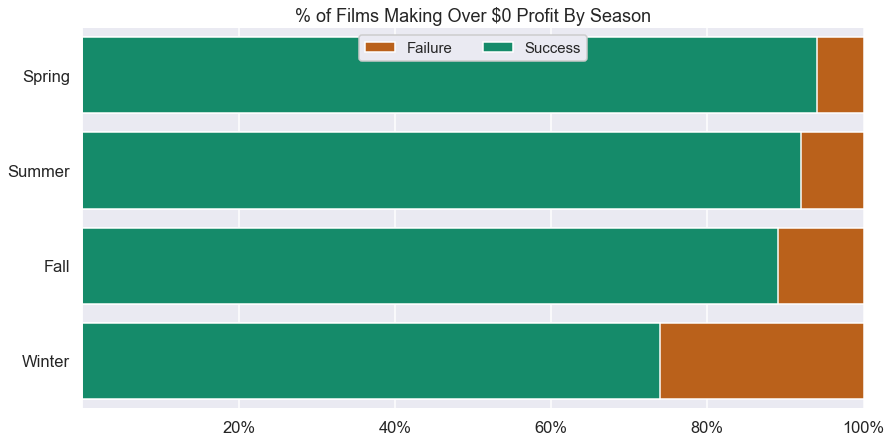

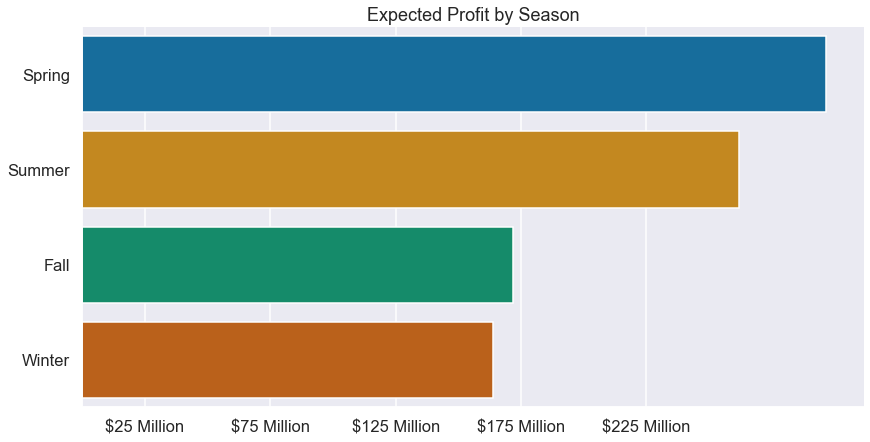

In [47]:
calculate_expected(target, 'season', 'Season',show_rates=True,
                  save=(True, 'figures/expseasons.png' ))

# Question 3 Conclusion

Judging by the output of the analysis, it seems the best time to release the recommended types of films is the Spring or Summer.

# Question 4

#### Who should we hire?

We'll start to analyze this question by exploring the data on movie professionals. Then, we'll slice the data to find a top 10 list for particular roles for the kind of movie we want to make.

In [48]:
#Check how many roles exist in the dataset
movies['category'].value_counts()

actor                  6829
producer               4783
actress                4102
writer                 3991
director               2985
composer               1683
cinematographer        1251
editor                  762
self                    351
production_designer     244
archive_footage          16
archive_sound             1
Name: category, dtype: int64

I'll analyze data for actors, actresses, director, producers, and writers.

To narrow down the most successful people I'll slice away anyone with that has passed away. 

Then, I'll slice only people who's movies have performed in the 'successful' range. To do that I'll group the dataframe by people's names, gathering the total boxoffice and average rating. 

Then I'll filter out people whose films have rated below the threshold for success, 6.3.

Finally, I'll take the top 10 people sorted by total profit and plot their numbers on a scatterplot showing their average audience rating. The size of the plot point shows their average film profit.  

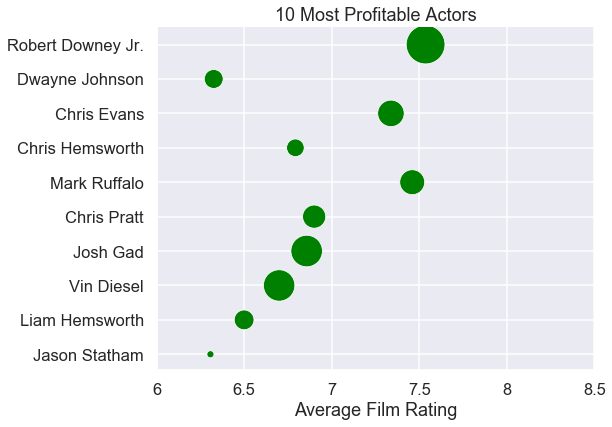

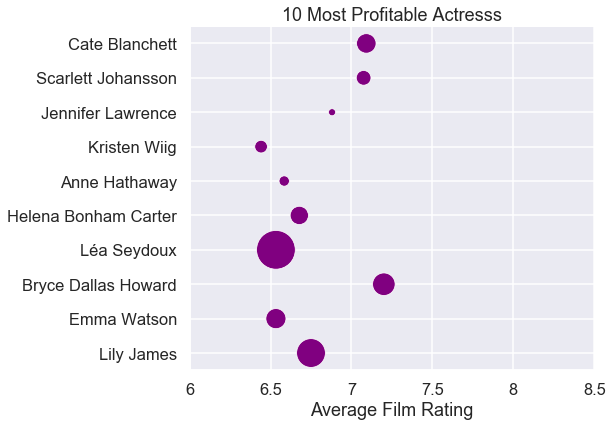

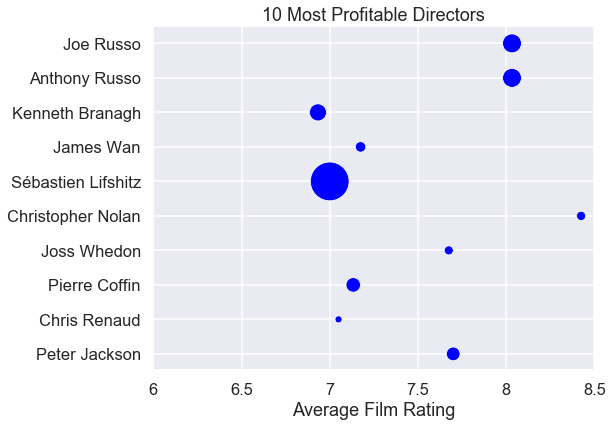

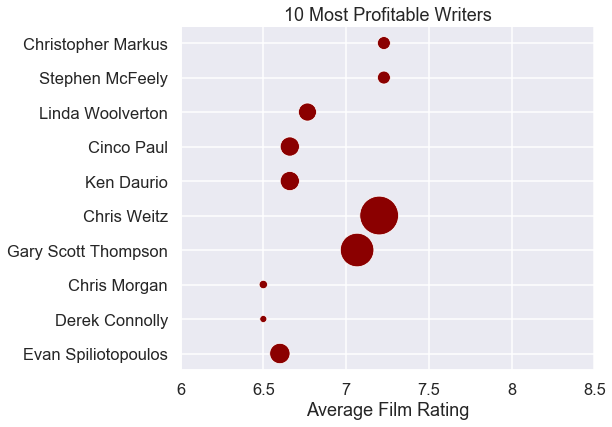

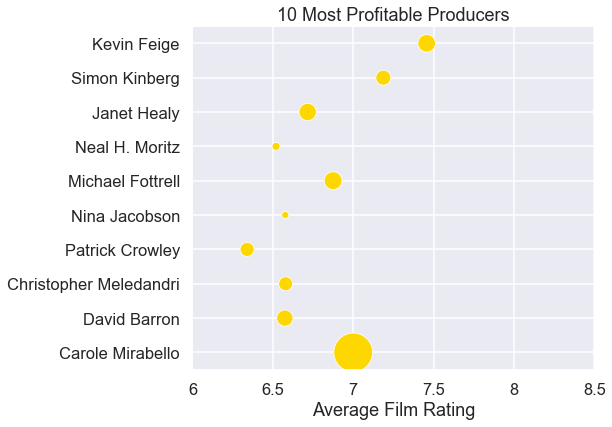

In [49]:
slice_role('actor','green', 
           save=(True, 'figures/actors.png')),
slice_role('actress','purple',
            save=(True, 'figures/acttresss.png')),
slice_role('director','blue',
           save=(True, 'figures/directors.png')), 
slice_role('writer', 'darkred',
           save=(True, 'figures/writers.png')),
slice_role('producer','gold',
           save=(True, 'figures/producers.png'))

# Question 4 Conclusion

Due to systemic biases it is important to note that the use of historical data should not be the only factor we use to hire cast and crew for a film. Although I can use the data to make a reccomendation, it is also important to recommend that we seek out diverse viewpoints and perspectives. This analysis is limited by the data it uses to automatically include historical biases that influence who has created successful films.  